In [1]:
# Importing Required libraries
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.metrics import log_loss, make_scorer, mean_absolute_error, accuracy_score,mean_squared_error,plot_confusion_matrix,confusion_matrix, classification_report
from warnings import warn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef



Using TensorFlow backend.
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

In [2]:
#loading the dataset
df= pd.read_csv("Aptamer_vs_DNA_Final.csv")
print(df.head(5))


                      Seq Seq Type  Seq Len  A_percent  C_percent  G_percent  \
0                TTGGCGAA      DNA        8  25.000000  12.500000  37.500000   
1      ATGGCTAGCGAAGCTAGA      DNA       18  33.333333  16.666667  33.333333   
2  CAAATGCTCCTAACCGACGTTT      DNA       22  27.272727  31.818182  13.636364   
3            GAGACCGGTAGC      DNA       12  25.000000  25.000000  41.666667   
4  CTTGTTGTTGTTCTCTGGTTCA      DNA       22   4.545455  18.181818  22.727273   

   T_percent  A_T ratio  C_G ratio    Purine  Pyrimidine  
0  25.000000   0.500000   0.500000  0.625000    0.375000  
1  16.666667   0.500000   0.500000  0.666667    0.333333  
2  27.272727   0.545455   0.454545  0.409091    0.590909  
3   8.333333   0.333333   0.666667  0.666667    0.333333  
4  54.545455   0.590909   0.409091  0.272727    0.727273  


Total sample: 4885
Percentage of DNA Sample: 95.35428459886785
Percentage of Aptamer Sample: 4.645715401132149


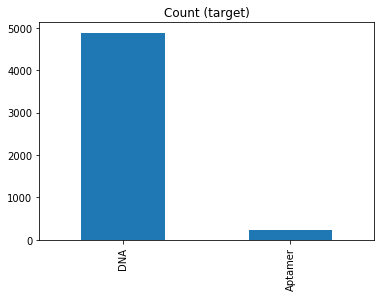

In [3]:
#Graphing the sample distribution
#%%script false --no-raise-error
print ('Total sample:',len(df[df['Seq Type']== 'DNA']))
print ('Percentage of DNA Sample:',float((len(df[df['Seq Type']== 'DNA'])))/(len(df['Seq Type']))*100)
print ('Percentage of Aptamer Sample:',float((len(df[df['Seq Type']== 'Aptamer'])))/(len(df['Seq Type']))*100)
df['Seq Type'].value_counts().plot(kind='bar', title='Count (target)');
plt.show()

In [4]:
#adds spaces in between letters
#this allows the vectoriser to treat each letter as a word. 
def add_spaces(Seq_joined):
    Seq_joined = re.sub('[^ACTG]', ' ', Seq_joined)
    Seq_sep=" ".join(Seq_joined)
    return Seq_sep
#Testing function
Secuencia=add_spaces('ATGCTCTGVVVV')
print(Secuencia)



A T G C T C T G        


In [5]:
df['Seq']=df['Seq'].apply(add_spaces)
print(df.head(2))

                                   Seq Seq Type  Seq Len  A_percent  \
0                      T T G G C G A A      DNA        8  25.000000   
1  A T G G C T A G C G A A G C T A G A      DNA       18  33.333333   

   C_percent  G_percent  T_percent  A_T ratio  C_G ratio    Purine  Pyrimidine  
0  12.500000  37.500000  25.000000        0.5        0.5  0.625000    0.375000  
1  16.666667  33.333333  16.666667        0.5        0.5  0.666667    0.333333  


In [6]:
#Spliting dataset according to Sequence Type
Aptamer_df=df[df['Seq Type']=='Aptamer']
print(Aptamer_df.shape)
DNA_df=df[df['Seq Type']=='DNA']
print(DNA_df.shape)

(238, 11)
(4885, 11)


In [7]:
#Creates word vectors and  encodes them as integers
#min_df=0.20,max_df=0.80 - optional  -  Specify arguements to limit the number of features generated
#cv =CountVectorizer(min_df=0.01, ngram_range=(6,6),stop_words = None,token_pattern = '\\b\\w+\\b')-best so far: Accuracy; 0.9970703125 con ['Seq Len']
cv =CountVectorizer( ngram_range=(6,6),min_df=0.05,stop_words = None,token_pattern = '\\b\\w+\\b',lowercase=False)
# Fit and apply  vectorizer
tokens = cv.fit_transform(Aptamer_df['Seq'])

# Print the features

print(cv.get_feature_names())
print(tokens.shape)



['A A G T G C', 'A C A G A G', 'A C C A G C', 'A C C G T G', 'A G A C A A', 'A G A G G T', 'A G A G T G', 'A G A T A G', 'A G C A C A', 'A G C A G C', 'A G C T T A', 'A G G G A G', 'A G G T C A', 'A G T A A G', 'A G T G C A', 'A T A C C A', 'A T A G T A', 'A T G C G T', 'A T T C A A', 'C A A T C T', 'C A C A G A', 'C A G A G G', 'C A G A T G', 'C A G C A C', 'C A G C T T', 'C C A G C T', 'C C G T G A', 'C C T A T G', 'C G G T G G', 'C G T G A A', 'C G T G C T', 'C T A C C G', 'C T A T G C', 'C T C A C A', 'C T C G G A', 'C T T A T T', 'G A A T T C', 'G A C A G G', 'G A C G C A', 'G A G G T C', 'G A T A G T', 'G C A A T C', 'G C A C A G', 'G C A G C A', 'G C G T G C', 'G C T A C C', 'G C T T A T', 'G G A C A G', 'G G A G A C', 'G G A G G G', 'G G C A G G', 'G G C G G G', 'G G G A G A', 'G G G A G G', 'G G G C G G', 'G G G G G G', 'G G G G G T', 'G G G G T G', 'G G G T G G', 'G G G T G T', 'G G G T T G', 'G G T C A G', 'G G T G G G', 'G G T G G T', 'G G T G T G', 'G G T T G G', 'G T A A 

In [8]:
#Creates word vectors and  encodes them as integers
#min_df=0.20,max_df=0.80 - optional  -  Specify arguements to limit the number of features generated
#cv =CountVectorizer(min_df=0.01, ngram_range=(6,6),stop_words = None,token_pattern = '\\b\\w+\\b')-best so far: Accuracy; 0.9970703125 con ['Seq Len']
DNAcv =CountVectorizer( ngram_range=(6,6),stop_words = None,token_pattern = '\\b\\w+\\b',lowercase=False)
# Fit and apply  vectorizer
DNAtokens = DNAcv.fit_transform(DNA_df['Seq'])

# Print the features

print(DNAcv.get_feature_names())
print(DNAtokens.shape)


['A A A A A A', 'A A A A A C', 'A A A A A G', 'A A A A A T', 'A A A A C A', 'A A A A C C', 'A A A A C G', 'A A A A C T', 'A A A A G A', 'A A A A G C', 'A A A A G G', 'A A A A G T', 'A A A A T A', 'A A A A T C', 'A A A A T G', 'A A A A T T', 'A A A C A A', 'A A A C A C', 'A A A C A G', 'A A A C A T', 'A A A C C C', 'A A A C C G', 'A A A C C T', 'A A A C G A', 'A A A C G C', 'A A A C G G', 'A A A C G T', 'A A A C T A', 'A A A C T C', 'A A A C T G', 'A A A C T T', 'A A A G A A', 'A A A G A C', 'A A A G A G', 'A A A G A T', 'A A A G C C', 'A A A G C G', 'A A A G C T', 'A A A G G A', 'A A A G G C', 'A A A G G G', 'A A A G G T', 'A A A G T A', 'A A A G T G', 'A A A G T T', 'A A A T A A', 'A A A T A C', 'A A A T A G', 'A A A T A T', 'A A A T C A', 'A A A T C C', 'A A A T C G', 'A A A T C T', 'A A A T G A', 'A A A T G C', 'A A A T G G', 'A A A T G T', 'A A A T T A', 'A A A T T C', 'A A A T T G', 'A A A T T T', 'A A C A A A', 'A A C A A C', 'A A C A A G', 'A A C A A T', 'A A C A C A', 'A A C A 

In [9]:
#Joining Aptamer tokens to data frame
tokens_array  = tokens.toarray()
print(tokens_array.shape)
cv_df = pd.DataFrame(tokens_array, columns=cv.get_feature_names()).add_prefix('k-mer_')
#Joining DNA tokens to data frame
DNAtokens_array  = DNAtokens.toarray()
print(DNAtokens_array.shape)
DNAcv_df = pd.DataFrame(DNAtokens_array, columns=DNAcv.get_feature_names()).add_prefix('k-mer_')
Apt_col_df=pd.concat([DNAcv_df,cv_df]).reset_index().dropna(axis=1)
#print(Apt_col_df.head())
#print(Apt_col_df.tail())
print(Apt_col_df.shape)
print(Apt_col_df.info())


# Add the new columns to the original DataFrame
tokenized_df = pd.concat([df, Apt_col_df], axis=1)
tokenized_df.drop(['Seq'], axis=1, inplace=True)
tokenized_df.drop(['index'], axis=1, inplace=True)
tokenized_df.astype({'Seq Type':str})
#tokenized_df.drop(['Seq Len'], axis=1, inplace=True)
#tokenized_df.drop(['k-mer_t t t t t t'], axis=1, inplace=True)
#tokenized_df.drop(['Seq Len'], axis=1, inplace=True) - Drops Accuracy to 0.9560546875
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
print(tokenized_df.head(2))
print(tokenized_df.shape)
tokenized_df.to_csv('Aptamer_columns_only.csv',index=False)
Apt_col_df.to_csv('Pre-Aptamer_columns_only.csv',index=False)

(238, 102)
(4885, 4009)
(5123, 102)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5123 entries, 0 to 5122
Columns: 102 entries, index to k-mer_T T C A A T
dtypes: int64(102)
memory usage: 4.0 MB
None
  Seq Type  Seq Len  A_percent  C_percent  G_percent  T_percent  A_T ratio  \
0      DNA        8  25.000000  12.500000  37.500000  25.000000        0.5   
1      DNA       18  33.333333  16.666667  33.333333  16.666667        0.5   

   C_G ratio    Purine  Pyrimidine  ...  k-mer_T G G G T G  k-mer_T G G G T T  \
0        0.5  0.625000    0.375000  ...                  0                  0   
1        0.5  0.666667    0.333333  ...                  0                  0   

   k-mer_T G G T G G  k-mer_T G G T G T  k-mer_T G G T T G  k-mer_T G T G G G  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   

   k-mer_T G T G G T  k-mer_T G T G T G  k-mer_T T A T T C  k-mer_T T C A

In [10]:
#PLOTTING THE KMERS
#list of Kmer columns
#kmers_cols = [col for col in tokenized_df.columns if 'k-mer_' in col]
#Subsetting aptamer and DNA columns
DNA_df=tokenized_df[tokenized_df['Seq Type']=='DNA']
Aptamer_df=tokenized_df[tokenized_df['Seq Type']=='Aptamer']

Kmer_DNA_Sum = DNA_df.iloc[:,10:111].sum()
Kmer_Aptamer_Sum = Aptamer_df.iloc[:,10:111].sum()
#Making Sum columns
Kmer_DNA_Sum_df= pd.DataFrame(Kmer_DNA_Sum, columns=['Sum'])
Kmer_Aptamer_Sum_df = pd.DataFrame(Kmer_Aptamer_Sum , columns=['Sum'])

# Fit MM_scaler to the DNA data
MM_scaler = MinMaxScaler()
MM_scaler.fit(Kmer_DNA_Sum_df[['Sum']])
Kmer_DNA_Sum_df['Sum_MM'] =MM_scaler.transform(Kmer_DNA_Sum_df[['Sum']])
print(Kmer_DNA_Sum_df.head())

# Fit MM_scaler to the Aptamer data
MM_A_scaler = MinMaxScaler()
MM_A_scaler.fit(Kmer_Aptamer_Sum_df[['Sum']])
Kmer_Aptamer_Sum_df['Sum_MM'] =MM_A_scaler.transform(Kmer_Aptamer_Sum_df[['Sum']])
print(Kmer_Aptamer_Sum_df.head())



                   Sum    Sum_MM
k-mer_A A G T G C    7  0.068182
k-mer_A C A G A G   11  0.113636
k-mer_A C C A G C   10  0.102273
k-mer_A C C G T G    4  0.034091
k-mer_A G A C A A   11  0.113636
                   Sum    Sum_MM
k-mer_A A G T G C   22  0.270270
k-mer_A C A G A G   16  0.108108
k-mer_A C C A G C   19  0.189189
k-mer_A C C G T G   15  0.081081
k-mer_A G A C A A   13  0.027027


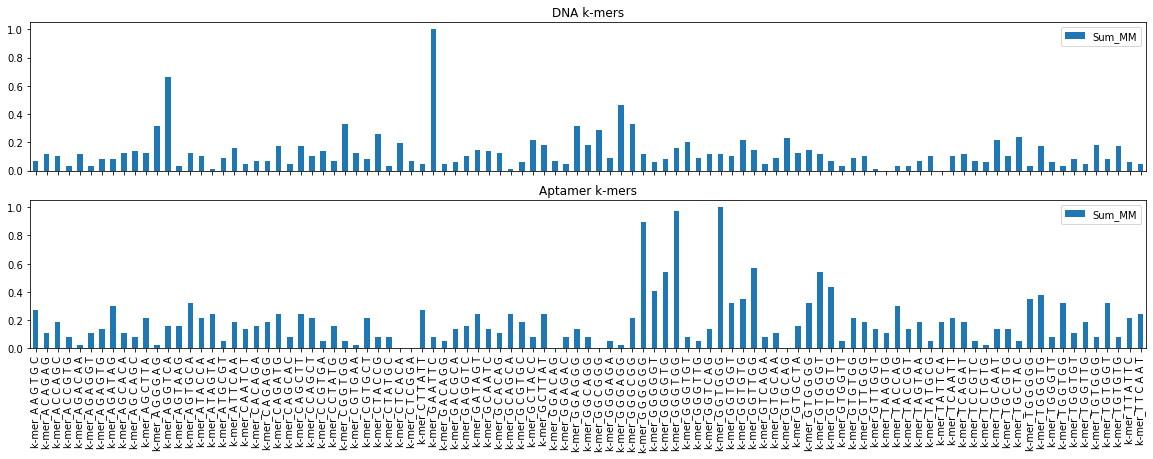

In [11]:
#Kmer plots by type
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20,6))
Kmer_DNA_Sum_df.plot(kind='bar',y='Sum_MM',ax=ax, title='DNA k-mers')
Kmer_Aptamer_Sum_df.plot(kind='bar',y='Sum_MM', ax=ax2, title='Aptamer k-mers')
#plt.ylim(0,0.03) 
plt.savefig('feature_selection')
plt.show()

In [12]:
#Code for multilabel_train_test_split
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [13]:
#Separating Label columns for Train and test split
LABEL = ['Seq Type']

# Get the columns that are features in the original df
NON_LABELS = [c for c in tokenized_df.columns if c not in LABEL]


In [14]:
# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(tokenized_df[NON_LABELS],pd.get_dummies(tokenized_df['Seq Type'],drop_first=True),0.2, seed=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.head)



(4099, 110) (1024, 110) (4099, 1) (1024, 1)
<bound method NDFrame.head of       Seq Len  A_percent  C_percent  G_percent  T_percent  A_T ratio  \
0           8  25.000000  12.500000  37.500000  25.000000   0.500000   
1          18  33.333333  16.666667  33.333333  16.666667   0.500000   
2          22  27.272727  31.818182  13.636364  27.272727   0.545455   
3          12  25.000000  25.000000  41.666667   8.333333   0.333333   
4          22   4.545455  18.181818  22.727273  54.545455   0.590909   
...       ...        ...        ...        ...        ...        ...   
5116       79  25.316456  16.455696  39.240506  18.987342   0.443038   
5117       26   0.000000   0.000000  65.384615  34.615385   0.346154   
5119       38  18.421053  15.789474  42.105263  18.421053   0.368421   
5120       40  22.500000  25.000000  32.500000  20.000000   0.425000   
5121       85  24.705882  16.470588  35.294118  23.529412   0.482353   

      C_G ratio    Purine  Pyrimidine  k-mer_A A G T G C  ...

In [16]:
#Calculatin P-values for all variables:   'A_percent', 'C_percent', 'G_percent',
      # 'T_percent', 'A_T ratio', 'C_G ratio', 'Purine', 'Pyrimidine'
from scipy import stats
col_list=[ 'A_percent', 'C_percent', 'G_percent','T_percent', 'A_T ratio', 'C_G ratio', 'Purine', 'Pyrimidine']
for col in col_list:
    popA=X_train[col]
    popB=X_test[col]
    print ('P-value stats for {}: {}'.format(col,stats.ttest_ind(popA,popB)))

P-value stats for A_percent: Ttest_indResult(statistic=0.12578027414441803, pvalue=0.8999107942196662)
P-value stats for C_percent: Ttest_indResult(statistic=-0.5047163320089036, pvalue=0.613779805214931)
P-value stats for G_percent: Ttest_indResult(statistic=-0.06319602495208088, pvalue=0.9496128765098328)
P-value stats for T_percent: Ttest_indResult(statistic=0.34885262097947634, pvalue=0.7272142980353982)
P-value stats for A_T ratio: Ttest_indResult(statistic=0.3329911057490157, pvalue=0.7391546282764487)
P-value stats for C_G ratio: Ttest_indResult(statistic=-0.3976380452389889, pvalue=0.6909135857217545)
P-value stats for Purine: Ttest_indResult(statistic=0.055195827698415335, pvalue=0.955984606065312)
P-value stats for Pyrimidine: Ttest_indResult(statistic=-0.1447394637700353, pvalue=0.884922275464412)


In [17]:
X_train.describe()

Seq Len    A_percent    C_percent    G_percent    T_percent  \
count  4099.000000  4099.000000  4099.000000  4099.000000  4099.000000   
mean     17.728226    24.179562    24.704946    26.659058    24.422894   
std      12.424995    10.387017    10.293813    11.334133    10.464385   
min       4.000000     0.000000     0.000000     4.545455     3.030303   
25%      12.000000    16.666667    18.181818    18.181818    16.666667   
50%      16.000000    22.727273    25.000000    26.666667    23.076923   
75%      22.000000    31.250000    31.818182    33.333333    31.250000   
max     132.000000    66.666667    63.636364    71.428571    66.666667   

         A_T ratio    C_G ratio       Purine   Pyrimidine  k-mer_A A G T G C  \
count  4099.000000  4099.000000  4099.000000  4099.000000        4099.000000   
mean      0.486025     0.513640     0.508386     0.491278           0.005855   
std       0.149194     0.149088     0.106874     0.106940           0.076304   
min       0.100000     0.105263     0.090909     0.100000           0.000000   
25%       0.379655     0.409091     0.454545     0.428571           0.000000   
50%       0.478261     0.516129     0.500000     0.500000           0.000000   
75%       0.590909     0.619048     0.571429     0.545455           0.000000   
max       0.894737     0.900000     0.900000     0.909091           1.000000   

       ...  k-mer_T G G G T G  k-mer_T G G G T T  k-mer_T G G T G G  \
count  ...        4099.000000        4099.000000        4099.000000   
mean   ...           0.008783           0.004391           0.005855   
std    ...           0.107870           0.069722           0.124832   
min    ...           0.000000           0.000000           0.000000   
25%    ...           0.000000           0.000000           0.000000   
50%    ...           0.000000           0.000000           0.000000   
75%    ...           0.000000           0.000000           0.000000   
max    ...           3.000000           2.000000           5.000000   

       k-mer_T G G T G T  k-mer_T G G T T G  k-mer_T G T G G G  \
count        4099.000000        4099.000000        4099.000000   
mean            0.005123           0.003903           0.007075   
std             0.071402           0.066160           0.089457   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           2.000000           2.000000   

       k-mer_T G T G G T  k-mer_T G T G T G  k-mer_T T A T T C  \
count        4099.000000        4099.000000        4099.000000   
mean            0.005611           0.006831           0.004879   
std             0.074706           0.093478           0.079503   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           3.000000           3.000000   

       k-mer_T T C A A T  
count        4099.000000  
mean            0.004879  
std             0.079503  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             3.000000  

[8 rows x 110 columns]

In [18]:
X_test.describe()

,Seq Len,A_percent,C_percent,G_percent,T_percent,A_T ratio,C_G ratio,Purine,Pyrimidine,k-mer_A A G T G C,...,k-mer_T G G G T G,k-mer_T G G G T T,k-mer_T G G T G G,k-mer_T G G T G T,k-mer_T G G T T G,k-mer_T G T G G G,k-mer_T G T G G T,k-mer_T G T G T G,k-mer_T T A T T C,k-mer_T T C A A T
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,...,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,17.003906,24.133914,24.886865,26.684047,24.295173,0.484291,0.515709,0.508180,0.491820,0.004883,...,0.005859,0.002930,0.003906,0.002930,0.007812,0.002930,0.008789,0.002930,0.005859,0.005859
std,11.240897,10.392456,10.409792,11.257041,10.540391,0.148355,0.148355,0.108153,0.108153,0.069740,...,0.088237,0.054074,0.062408,0.054074,0.098560,0.054074,0.112385,0.054074,0.076359,0.076359
min,4.000000,0.000000,0.000000,4.545455,3.448276,0.142857,0.105263,0.136364,0.105263,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,16.666667,18.181818,18.181818,16.666667,0.379464,0.409091,0.454545,0.428571,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,22.727273,25.000000,26.315789,23.076923,0.475000,0.525000,0.500000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,31.250000,31.818182,33.333333,31.250000,0.590909,0.620536,0.571429,0.545455,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,108.000000,60.000000,60.000000,81.818182,60.000000,0.894737,0.857143,0.894737,0.863636,1.000000,...,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000


In [15]:
def plot_decision_boundaries(X, y, model_class, **model_params):
    """
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator

    """
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4,cmap='gray')
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8,cmap='PuOr')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

In [16]:
%%script false --no-raise-error
num_features=[1,5,10,20,30,40,50,60,70,80,90,100,109]
#num_features=[1,5,10,15,20,25,30]
for i in num_features:
    print("Number of features:{}".format(i))
# Create the RFE with a LogisticRegression estimator and X features to select
    rfe = RFE(estimator=OneVsRestClassifier(LogisticRegression(solver='lbfgs',max_iter=3000,multi_class='multinomial',warm_start=True,C=1)), n_features_to_select=i,step=10, verbose=1)
# Fits the eliminator to the data
    rfe.fit(X_train, y_train)

# Print the features that are not eliminated
    print(X_train.columns[rfe.support_])

# Calculates the test set accuracy
    acc = accuracy_score(y_train, rfe.predict(X_train))
    print("{0:.1%} accuracy on train set.".format(acc)) 
    

In [17]:
%%script false --no-raise-error
#Drop columns that were not selected
lr_feature_list=['k-mer_A G C A G C', 'k-mer_A G C T T A',
       'k-mer_A G G G A G', 'k-mer_A G G T C A', 'k-mer_C A G A T G',
       'k-mer_C T A C C G', 'k-mer_C T C A C A', 'k-mer_G A A T T C',
       'k-mer_G A G G T C', 'k-mer_G A T A G T', 'k-mer_G C A C A G',
       'k-mer_G G A G G G', 'k-mer_G G C A G G', 'k-mer_G G C G G G',
       'k-mer_G G G A G G', 'k-mer_G G G C G G', 'k-mer_G G G G G G',
       'k-mer_G G G G G T', 'k-mer_G G T G G T', 'k-mer_G G T G T G',
       'k-mer_G T G C A G', 'k-mer_G T G G T T', 'k-mer_T C T G T G',
       'k-mer_T G C T A C', 'k-mer_T G G T G G', 'k-mer_T G G T T G',
       'k-mer_T G T G G G', 'k-mer_T G T G G T', 'k-mer_T G T G T G']
X_train=X_train[X_train.columns[X_train.columns.isin(lr_feature_list)]]


In [18]:
#Finding the best parameters for LogisticRegression
#Specify l regularization
lr = LogisticRegression(solver='lbfgs',max_iter=2000,multi_class='multinomial',warm_start=True,random_state=111,class_weight='balanced')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1,2, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

''' 
Best CV params {'C': 1}
Total number of features: 110
Number of selected features: 110
'''


/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best CV params {'C': 2}
Total number of features: 110
Number of selected features: 110


" \nBest CV params {'C': 1}\nTotal number of features: 110\nNumber of selected features: 110\n"

In [55]:
def balanced_accuracy(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    return 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    print('confusion matrix')
    print(np.array([[tp,fp],[fn,tn]]))
    print('sensitivity is ',1.*tp/(tp+fn))
    print('specificity is ',1.*tn/(tn+fp))
    print('accuracy is ',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is ',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('matthews_corrcoef is', matthews_corrcoef(true,pred))

In [17]:
#LogisticRegression Cross Validation
LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs',max_iter=3000,multi_class='multinomial', warm_start=True, C=2,class_weight='balanced' ))
acc = make_scorer(balanced_accuracy)

# Set up cross_val_score
cv = cross_val_score(estimator=LR,
                     X=X_train,
                     y=y_train,
                     cv=10,
                     scoring=acc)

# Print the mean error
print(cv)
print(cv.mean())

[0.94097456 0.96601158 0.96730769 0.9474359  0.99358974 0.875
 0.9724359  0.99358974 0.99871795 0.94608637]
0.9601149428262769


Logistic Regression Model
confusion matrix
[[978   2]
 [  5  39]]
sensitivity is  0.9949135300101729
specificity is  0.9512195121951219
accuracy is  0.9931640625
balanced accuracy is  0.9730665211026475
matthews_corrcoef is 0.9147059855567101


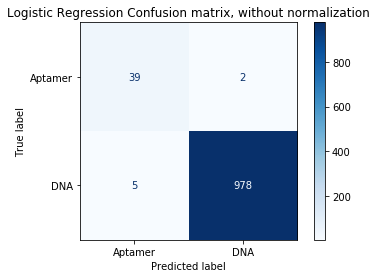

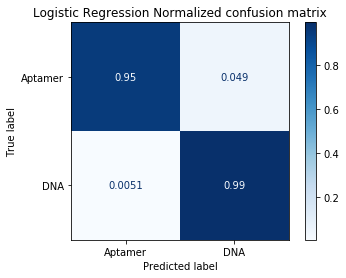

In [18]:
#X_test=X_test[X_test.columns[X_test.columns.isin(lr_feature_list)]]
#Logistic Regression Model
LR.fit(X_train,y_train)

#Calcular las metricas de manera independiente
lr_y_pred = LR.predict(X_test)
    
print('Logistic Regression Model')
display_summary(y_test,lr_y_pred)   
titles_options = [("Logistic Regression Confusion matrix, without normalization", None),
                  ("Logistic Regression Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(LR, X_test, y_test,
                                 display_labels=['Aptamer','DNA'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()


In [20]:
%%script false --no-raise-error
plt.figure(figsize=(20,20))
plt.title('Logistic Regresion Model',fontsize=24)
plt.xlabel("Aptamer",fontsize=24)
plt.ylabel("DNA",fontsize=24)
plot_decision_boundaries(X_train, y_train,LogisticRegression)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)         
plt.savefig('Logic')
plt.show()

In [23]:
%%script false --no-raise-error
# finding the best parameters for the RandomForestRegressor
# Instantiate the RandomForestRegressor
rfc =RandomForestClassifier( random_state=1111,class_weight='balanced')
# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(rfc, {'n_estimators':[10,20,25,30,50,75,100,105,110,115,120,125,130,135,150,175,200,250]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best rfcGS params", searcher.best_params_)
#saving the best parameter into a variable
estimator=searcher.best_params_



In [24]:
%%script false --no-raise-error
#Validating RandomForestRegressor
rfc =RandomForestClassifier(n_estimators=estimator['n_estimators'] , random_state=1111,class_weight='balanced')
acc = make_scorer(balanced_accuracy)

# Set up cross_val_score
cv = cross_val_score(estimator=rfc,
                     X=X_train,
                     y=y_train,
                     cv=10,
                     scoring=acc)

# Print the mean error
print(cv)
print(cv.mean())

In [25]:
%%script false --no-raise-error
#for n in [10,20,25,30,50,75,100,105,110,115,120,125,130,135,150,175,200,250,300,350]:
# Instantiate the RandomForestRegressor
rfc = RandomForestClassifier(n_estimators=estimator['n_estimators'] , random_state=1111,class_weight='balanced')
rfc.fit(X_train, y_train)
#Calcular las metricas de manera independiente
rfc_y_pred = rfc.predict(X_test)

    
print('Random Forest Classifier')
display_summary(y_test,rfc_y_pred)   
titles_options = [("Random Forest Classifier matrix, without normalization", None),
                  ("Random Forest Classifier Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfc, X_test, y_test,
                                 display_labels=['Aptamer','DNA'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()


In [38]:
#%%script false --no-raise-error
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1],'class_weight':['balanced']}
searcher = GridSearchCV(svm, parameters )
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
CGamma=searcher.best_params_
# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

'''
Best CV params {'C': 10, 'gamma': 0.01}
Best CV accuracy 0.9955225785549136
Test accuracy of best grid search hypers: 0.9943705220061413
'''    
    

/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d arr

Best CV params {'C': 1, 'class_weight': 'balanced', 'gamma': 0.01}
Best CV accuracy 0.9899979153637689
Test accuracy of best grid search hypers: 0.9921875


"\nBest CV params {'C': 10, 'gamma': 0.01}\nBest CV accuracy 0.9955225785549136\nTest accuracy of best grid search hypers: 0.9943705220061413\n"

In [39]:
#SVC Validation 
svm = SVC(C=CGamma['C'], gamma=CGamma['gamma'],class_weight='balanced')
cv = cross_val_score(estimator=svm,
                     X=X_train,
                     y=y_train,
                     cv=10,
                     scoring=acc)


#the mean error
print(cv)
print(cv.mean())



/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d arr

[0.93969579 0.9435321  0.96987179 0.87371795 0.9724359  0.875
 0.975      0.97371795 0.94871795 0.91977058]
0.9391460009457049


/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Support Vectors Model
confusion matrix
[[980   5]
 [  3  36]]
sensitivity is  0.9969481180061037
specificity is  0.8780487804878049
accuracy is  0.9921875
balanced accuracy is  0.9374984492469542
matthews_corrcoef is 0.8962409475926725


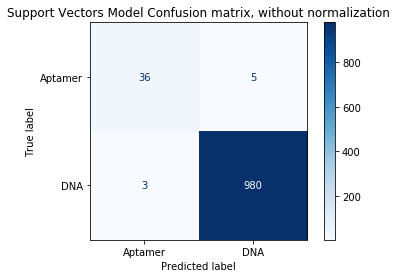

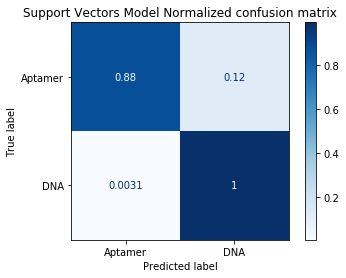

In [56]:
#Support Vectors Model
svm = SVC(C=CGamma['C'], gamma=CGamma['gamma'],probability=True,class_weight='balanced')
svm.fit(X_train, y_train)

svm_y_pred = svm.predict(X_test)
    
print('Support Vectors Model')
display_summary(y_test,svm_y_pred)   
titles_options = [("Support Vectors Model Confusion matrix, without normalization", None),
                  ("Support Vectors Model Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svm, X_test, y_test,
                                 display_labels=['Aptamer','DNA'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In [57]:
%%script false --no-raise-error
plt.figure(figsize=(20,20))
plt.title('Support Vectors Model',fontsize=24)
plt.xlabel("Aptamer",fontsize=24)
plt.ylabel("DNA",fontsize=24)
plot_decision_boundaries(X_train, y_train,SVC,C=10, gamma=0.01)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('SVM')
plt.show()

Best CV params {'max_features': 'sqrt'}
Best CV accuracy 0.9919500282914917
[0.91593754 0.99744246 0.7974359  0.84871795 0.92371795 0.8724359
 0.9        0.89871795 0.84871795 0.91977058]
0.8922894167348334
Decision Tree Classifier
confusion matrix
[[982   2]
 [  1  39]]
sensitivity is  0.9989827060020345
specificity is  0.9512195121951219
accuracy is  0.9970703125
balanced accuracy is  0.9751011090985782
matthews_corrcoef is 0.9615174763989933


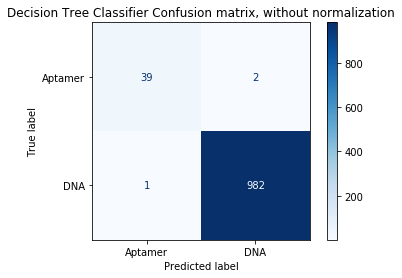

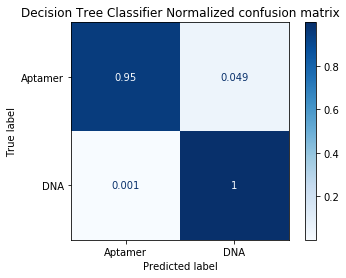

In [58]:
from sklearn.tree import DecisionTreeClassifier
# Instantiate an RBF SVM
dtc = DecisionTreeClassifier()

# Instantiate the GridSearchCV object and run the search
parameters = {'max_features':['sqrt', 'log2']}
searcher = GridSearchCV(dtc, parameters )
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
MC=searcher.best_params_

#SVC Validation 
dtc = DecisionTreeClassifier(max_features=MC['max_features'], class_weight='balanced')
cv = cross_val_score(estimator=dtc,
                     X=X_train,
                     y=y_train,
                     cv=10,
                     scoring=acc)


#the Cross Validation Balanced Accuracy
print(cv)
print(cv.mean())

dtc.fit(X_train, y_train)

dtc_y_pred = dtc.predict(X_test)

    
print('Decision Tree Classifier')
display_summary(y_test,dtc_y_pred)   
titles_options = [("Decision Tree Classifier Confusion matrix, without normalization", None),
                  ("Decision Tree Classifier Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dtc, X_test, y_test,
                                 display_labels=['Aptamer','DNA'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()



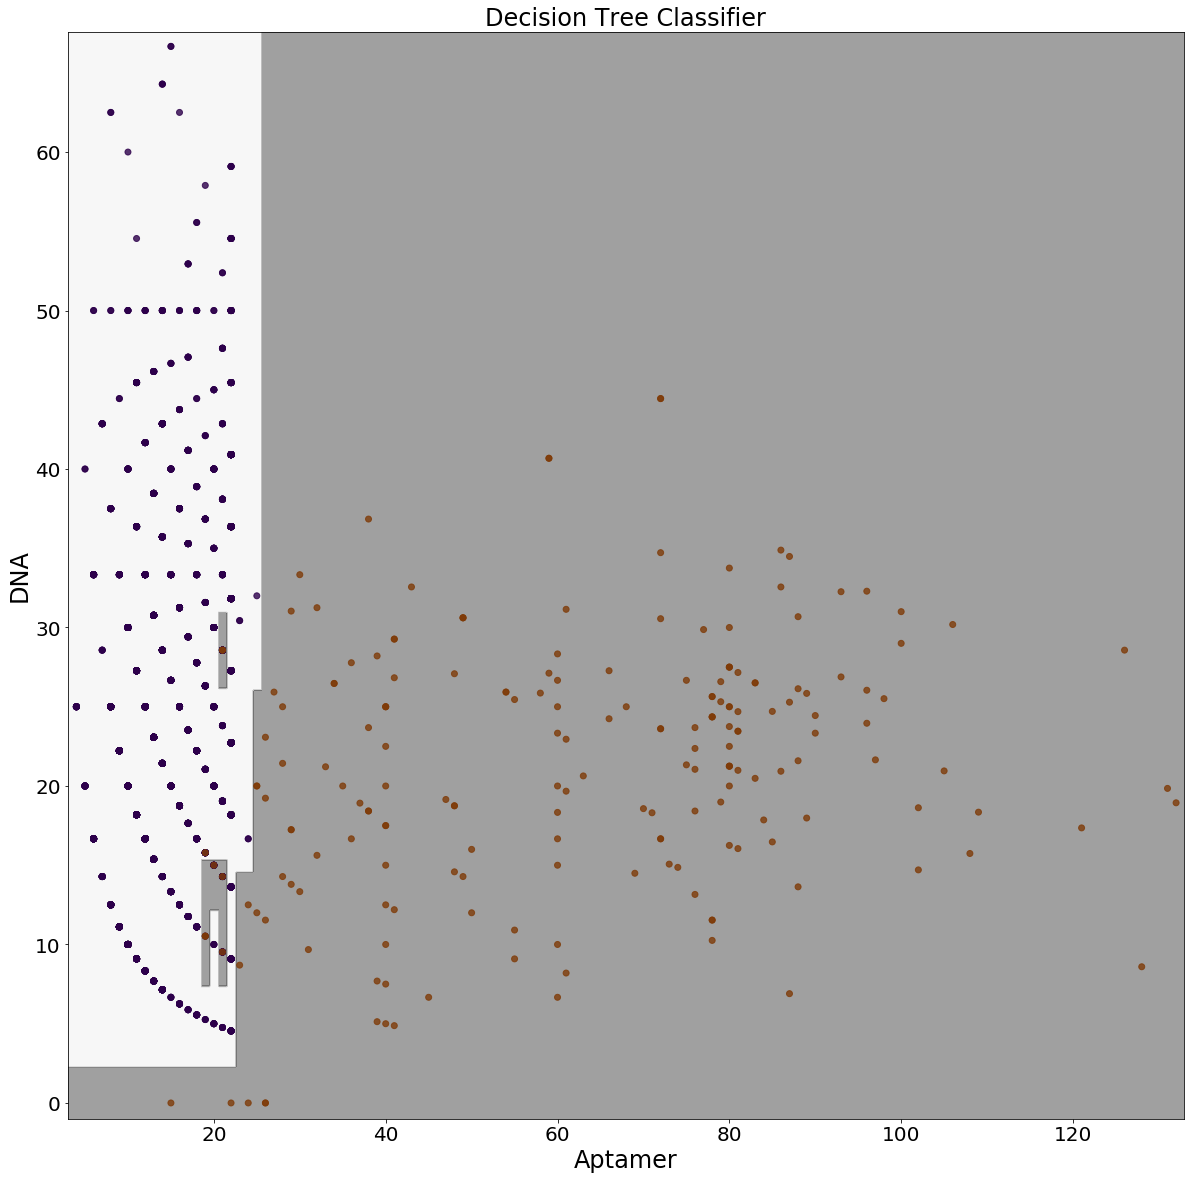

In [59]:
plt.figure(figsize=(20,20))
plt.title('Decision Tree Classifier',fontsize=24)
plt.xticks(fontsize=50)
plt.xlabel("Aptamer",fontsize=24)
plt.ylabel("DNA",fontsize=24)
plot_decision_boundaries(X_train, y_train,DecisionTreeClassifier, class_weight='balanced')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('DecisionTree')
plt.show()

/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/francesheredia/anaconda2/envs/Py3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d arr

[0.86350787 0.82366402 0.76089744 0.83269231 0.93141026 0.86153846
 0.88141026 0.86153846 0.95384615 0.82611336]
0.8596618587586417
Gaussian Naive Baiyes Classifier
confusion matrix
[[903   5]
 [ 80  36]]
sensitivity is  0.9186164801627671
specificity is  0.8780487804878049
accuracy is  0.9169921875
balanced accuracy is  0.898332630325286
matthews_corrcoef is 0.4928022115606366


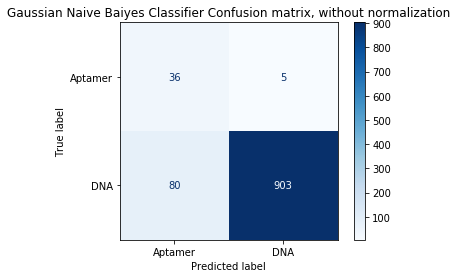

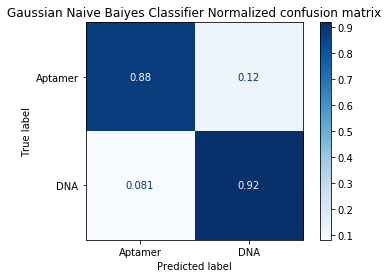

In [60]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Naive Baiyes Classifier
gnb = GaussianNB()


#GNB Validation 

cv = cross_val_score(estimator=gnb,
                     X=X_train,
                     y=y_train,
                     cv=10,
                     scoring=acc)


#the Cross Validation Balanced Accuracy
print(cv)
print(cv.mean())

gnb.fit(X_train, y_train)

gnb_y_pred = gnb.predict(X_test)

    
print('Gaussian Naive Baiyes Classifier')
display_summary(y_test,gnb_y_pred)   
titles_options = [("Gaussian Naive Baiyes Classifier Confusion matrix, without normalization", None),
                  ("Gaussian Naive Baiyes Classifier Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gnb, X_test, y_test,
                                 display_labels=['Aptamer','DNA'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In [61]:
%%script false --no-raise-error
plt.figure(figsize=(20,20))
plt.title('Gaussian Naive Baiyes Classifier',fontsize=24)
plt.xticks(fontsize=50)
plt.xlabel("Aptamer",fontsize=24)
plt.ylabel("DNA",fontsize=24)
plot_decision_boundaries(X_train, y_train,GaussianNB)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('NaiveBaiyes')
plt.show()

In [62]:
%%script false --no-raise-error
# ADA boosting Load libraries
from sklearn.ensemble import AdaBoostClassifier
# Create adaboost classifer object
abc = AdaBoostClassifier()


# Instantiate the GridSearchCV object and run the search
parameters = {'n_estimators':[10,20,30,50,75,100,110,120,130,150,175,200,250]}
searcher = GridSearchCV(abc, parameters )
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
N=searcher.best_params_

#SVC Validation 
abc = AdaBoostClassifier(n_estimators=N['n_estimators'])
cv = cross_val_score(estimator=abc,
                     X=X_train,
                     y=y_train,
                     cv=10,
                     scoring=acc)


#the Cross Validation Balanced Accuracy
print(cv)
print(cv.mean())

abc.fit(X_train, y_train)

abc_y_pred = abc.predict(X_test)

    
print('Ada Boost Classifier')
display_summary(y_test,abc_y_pred)   
titles_options = [("Ada Boost Classifier Confusion matrix, without normalization", None),
                  ("Ada Boost Classifier Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(abc, X_test, y_test,
                                 display_labels=['Aptamer','DNA'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

In [67]:
%%script false --no-raise-error
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# Models to plot Logic, rfc , p_Logic , svm

# predict probabilities
lr_probs =LR.predict_proba(X_test)
svm_probs =svm.predict_proba(X_test)

dtc_probs =dtc.predict_proba(X_test)
gnb_probs =gnb.predict_proba(X_test)  


# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
dtc_probs = dtc_probs[:, 1]

svm_probs = svm_probs[:,1]
gnb_probs = gnb_probs[:,1]


# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

svm_auc =  roc_auc_score(y_test,svm_probs)
dtc_auc = roc_auc_score(y_test, dtc_probs)
gnb_auc =  roc_auc_score(y_test,gnb_probs)


# summarize scores
print('No Skill: ROC AUC=%.4f' % (ns_auc))
print('Logistic: ROC AUC=%.4f' % (lr_auc))

print('Support Vectors: ROC AUC=%.4f' % (svm_auc))
print('Decision Trees: ROC AUC=%.4f' % (dtc_auc))
print('GaussianNB: ROC AUC=%.4f' % (gnb_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
dtc_fpr, dtc_tpr, _ = roc_curve(y_test, dtc_probs)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_probs)

# plot the roc curve for the model
plt.figure(figsize=(20, 10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(dtc_fpr, dtc_tpr, marker='.', label='Decision Trees')
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vectors')
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='GaussianNB')
# axis labels

plt.xlabel('False Positive Rate',fontsize=24)
plt.ylabel('True Positive Rate',fontsize=24)
# show the legend
plt.legend(fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#save the plot 
plt.savefig('ROC')
# show the plot
plt.show()

In [68]:
print(y_test.head)

<bound method NDFrame.head of       DNA
6       1
7       1
13      1
14      1
19      1
...   ...
5094    0
5105    0
5109    0
5118    0
5122    0

[1024 rows x 1 columns]>


In [69]:
%%script false --no-raise-error
from sklearn.metrics import precision_recall_curve,auc
from sklearn.metrics import average_precision_score
# predict probabilities
lr_probs =LR.predict_proba(X_test)
svm_probs =svm.predict_proba(X_test)
dtc_probs =dtc.predict_proba(X_test)
gnb_probs =gnb.predict_proba(X_test) 

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 0]
dtc_probs = dtc_probs[:, 0]
svm_probs = svm_probs[:,0]
gnb_probs = gnb_probs[:,0]


# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)

# calculate model precision-recall curve

lr_precision, lr_recall, _  = precision_recall_curve(y_test, lr_probs)
svm_precision, svm_recall, _  =  precision_recall_curve(y_test,svm_probs)
dtc_precision, dtc_recall, _  = precision_recall_curve(y_test, dtc_probs)
gnb_precision, gnb_recall, _  =  precision_recall_curve(y_test,gnb_probs)


# calculate area under curve

lr_auc_score =average_precision_score(y_test, lr_probs)
svm_auc_score =average_precision_score(y_test,svm_probs)
dtc_auc_score =average_precision_score(y_test, dtc_probs)
gnb_auc_score =average_precision_score(y_test,gnb_probs)


# summarize scores

print('Logistic: PR AUC=%.3f' % (lr_auc_score))
print('Support Vectors: PR AUC=%.3f' % (svm_auc_score))
print('Decision Trees: PR AUC=%.3f' % (dtc_auc_score))
print('GaussianNB: PR AUC=%.3f' % (gnb_auc_score))


# plot the model precision-recall curve
plt.figure(figsize=(20, 10))
plt.plot(lr_precision, lr_recall, marker='.', label='Logistic Regression')
plt.plot (dtc_precision,dtc_recall, marker='.', label='Decision Trees')

plt.plot(svm_precision, svm_recall, marker='.', label='Support Vectors')
plt.plot(gnb_precision, gnb_recall, marker='.', label='GaussianNB')


# axis labels

plt.xlabel('Recall',fontsize=18)
plt.ylabel('Precision',fontsize=18)
# show the legend
plt.legend(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.savefig('PR Curve')
# show the plot
plt.show()

In [70]:
%%script false --no-raise-error
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
weights=compute_sample_weight(class_weight='balanced', y=y_test)

display1 =plot_precision_recall_curve(LR, X_test, y_test,sample_weight=weights)
display2=plot_precision_recall_curve(svm, X_test, y_test,sample_weight=weights)
display3=plot_precision_recall_curve(dtc, X_test, y_test,sample_weight=weights)
display4=plot_precision_recall_curve(gnb, X_test, y_test,sample_weight=weights)

# plot the data


plt.show()
